In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
file_folder = '../data'

In [3]:
train = pd.read_csv(f'{file_folder}/train.csv.zip')
test = pd.read_csv(f'{file_folder}/test.csv.zip')
structures = pd.read_csv(f'{file_folder}/structures.csv.zip')

print(f'There are {train.shape[0]} in train df')
print(f'There are {test.shape[0]} in test df')
print(f'There are {structures.shape[0]} in structures df')

There are 4658147 in train df
There are 2505542 in test df
There are 2358657 in structures df


In [4]:
print(train.head())
print('---------------')
print(test.head())
print('---------------')
print(structures.head())


   id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant  
0                   84.8076  
1                  -11.2570  
2                  -11.2548  
3                  -11.2543  
4                   84.8074  
---------------
        id     molecule_name  atom_index_0  atom_index_1  type
0  4658147  dsgdb9nsd_000004             2             0  2JHC
1  4658148  dsgdb9nsd_000004             2             1  1JHC
2  4658149  dsgdb9nsd_000004             2             3  3JHH
3  4658150  dsgdb9nsd_000004             3             0  1JHC
4  4658151  dsgdb9nsd_000004             3             1  2JHC
---------------
      molecule_name  atom_index atom       

# Feature engineering

Using the features created from 

    - https://www.kaggle.com/artgor/molecular-properties-eda-and-models
    - https://www.kaggle.com/artgor/brute-force-feature-engineering
 

In [5]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [7]:
print(train.head())
print('---------------')
print(test.head())
print('---------------')
print(structures.head())

   id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant atom_0       x_0       y_0       z_0 atom_1  \
0                   84.8076      H  0.002150 -0.006031  0.001976      C   
1                  -11.2570      H  0.002150 -0.006031  0.001976      H   
2                  -11.2548      H  0.002150 -0.006031  0.001976      H   
3                  -11.2543      H  0.002150 -0.006031  0.001976      H   
4                   84.8074      H  1.011731  1.463751  0.000277      C   

        x_1       y_1       z_1  
0 -0.012698  1.085804  0.008001  
1  1.011731  1.463751  0.000277  
2 -0.540815  1.447527 -0.876644  
3 -0.523814  1.437933  0.906397  
4 -0.012698 

In [10]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [12]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])
train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

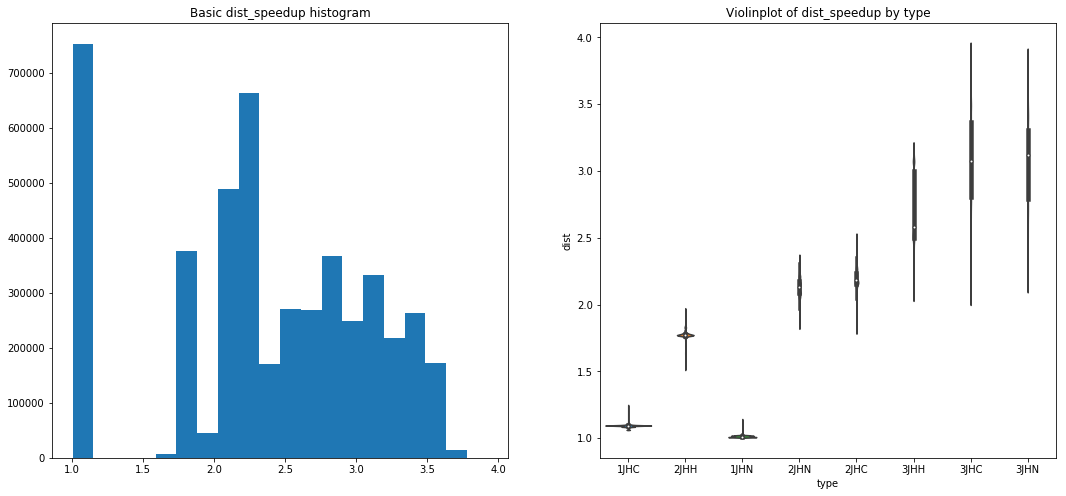

In [15]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1, 2, 1);
plt.hist(train['dist'], bins=20);
plt.title('Basic dist_speedup histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='dist', data=train);
plt.title('Violinplot of dist_speedup by type');

In [16]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_0_mean'] = train['dist'] / train.groupby('type_0')['dist'].transform('mean')
test['dist_to_type_0_mean'] = test['dist'] / test.groupby('type_0')['dist'].transform('mean')

train['dist_to_type_1_mean'] = train['dist'] / train.groupby('type_1')['dist'].transform('mean')
test['dist_to_type_1_mean'] = test['dist'] / test.groupby('type_1')['dist'].transform('mean')

In [17]:
train[f'molecule_type_dist_mean'] = train.groupby(['molecule_name', 'type'])['dist'].transform('mean')
test[f'molecule_type_dist_mean'] = test.groupby(['molecule_name', 'type'])['dist'].transform('mean')